In [1]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

In [2]:
#connect with sql

db = pymysql.connect(
    host='localhost',
    user='root',
    password='Sayali@123',
    database='ecommerce'
)
cursor = db.cursor()


## 1. List all unique cities where all customers are located.

In [3]:
query1 = ''' SELECT DISTINCT customer_city from customers'''

cursor.execute(query1)

data = cursor.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


##  2. Count the number of orders placed in 2017.

In [4]:
query1 = ''' select
               count(order_id) as orders 
           from 
               orders
           where 
               order_estimated_delivery_date = 2017
        '''

cursor.execute(query1)

data = cursor.fetchall()
print(' The total number of orders placed in 2017 are :', data[0][0])

 The total number of orders placed in 2017 are : 80634


## 3. Find the total sales per category.

In [33]:
query1 = ''' SELECT 
     upper(products.product_category) as category, round(SUM(payments.payment_value),2) as sales
        FROM products
        Join order_items
	    ON 
    products.product_id = order_items.product_id
        join payments
         on 
    payments.order_id = order_items.order_id
GROUP BY category;
        '''

cursor.execute(query1)

data = cursor.fetchall()
pd.DataFrame(data,columns=('Product_Category','Sales'))

,Product_Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


## 4. Calculate the percentage of orders that were paid in installments.

In [6]:
query = '''select (sum(case when payment_installments >=1 then 1 else 0 end)/count(*))*100 from payments'''

cursor.execute(query)

data = cursor.fetchall()

print('Percentage of orders that were paid in installments is',data[0][0])

Percentage of orders that were paid in installments is 99.9981


## 5. Count the number of customers from each state. 

In [7]:
query = ''' select customer_state , count(customer_id) from customers group by customer_state'''

cursor.execute(query)
data = cursor.fetchall()
df=pd.DataFrame(data, columns=('state','customer_count'))
df=df.sort_values(by='customer_count',ascending=False)
df


,state,customer_count
0,SP,83492
4,RJ,25704
2,MG,23270
5,RS,10932
3,PR,10090
1,SC,7274
9,BA,6760
13,DF,4280
8,ES,4066
7,GO,4040


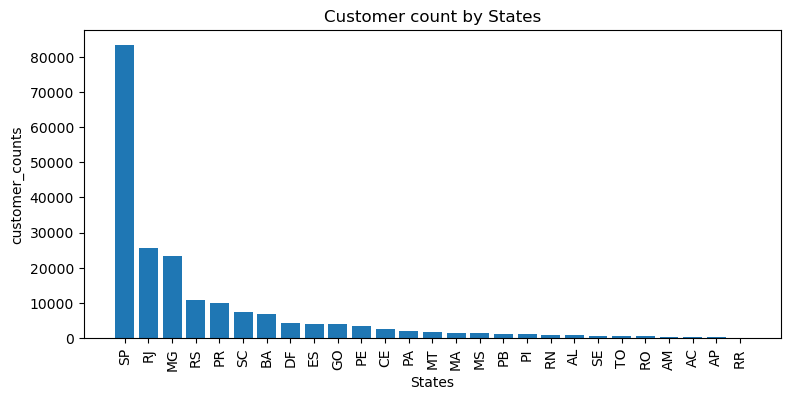

In [8]:
plt.figure(figsize=(9,4))
plt.bar(df['state'],df['customer_count'])
plt.xticks(rotation=90)
plt.title('Customer count by States')
plt.xlabel('States')
plt.ylabel('customer_counts')
plt.show()

#### State SP has highest customers

## Intermediate Queries
## 1. Calculate the number of orders per month in 2018.

In [9]:
query = ''' select
     monthname(order_purchase_timestamp) month, count(order_id) as order_count
     from orders
    where year(order_purchase_timestamp)=2018
    group by month '''

cursor.execute(query)
data = cursor.fetchall()

#df=pd.DataFrame(data, columns=('state','customer_count'))

df = pd.DataFrame(data,columns=('Months','Order_count'))
df

,Months,Order_count
0,July,12584
1,August,13024
2,February,13456
3,June,12334
4,March,14422
5,January,14538
6,May,13746
7,April,13878
8,September,32
9,October,8


<IPython.core.display.Javascript object>

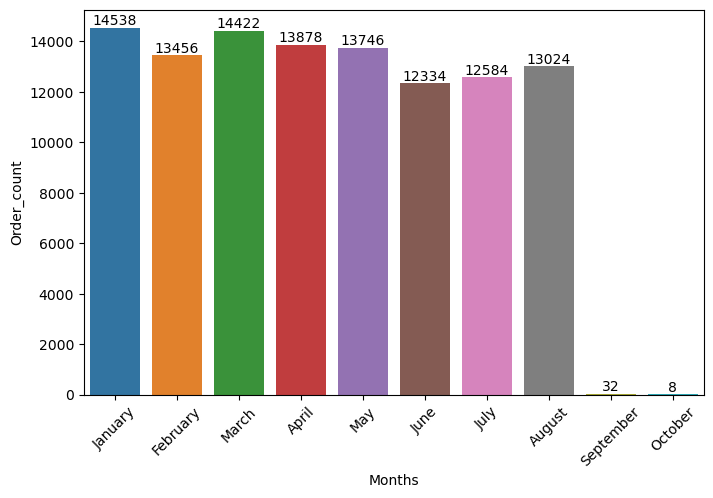

In [10]:
M_order = ['January','February','March','April','May','June','July','August','September','October']

plt.figure(figsize=(8,5))
ax=sns.barplot(x=df['Months'],y=df['Order_count'], order = M_order)
plt.xticks(rotation=45)
plt.xlabel('Months')
plt.ylabel('Order_count')
ax.bar_label(ax.containers[0])
plt.show()

#### January has highest number of orders in 2018.

## 2. Find the average number of products per order, grouped by customer city.

In [11]:
query = ''' with count_per_order as (select
orders.customer_id, orders.order_id, count(order_items.order_item_id) as oc
from order_items
join orders
on order_items.order_id = orders.order_id
group by orders.customer_id, orders.order_id)
select customers.customer_city as city, round(avg(count_per_order.oc),2) as customer_avg
 from customers
join count_per_order 
on customers.customer_id = count_per_order.customer_id
group by city
order by customer_avg desc '''

cursor.execute(query)

data = cursor.fetchall()

df=pd.DataFrame(data, columns=('City','Avg_product/order'))
df.head(10)

,City,Avg_product/order
0,padre carvalho,14.00
1,celso ramos,13.00
2,datas,12.00
3,candido godoi,12.00
4,matias olimpio,10.00
5,cidelandia,8.00
6,curralinho,8.00
7,picarra,8.00
8,morro de sao paulo,8.00
9,teixeira soares,8.00


## 3. Calculate the percentage of total revenue contributed by each product category.

In [12]:
query = ''' 
          SELECT 
     upper(products.product_category) as category, round(SUM(payments.payment_value)/(select sum(payment_value) from payments)*100,2) as sales_per
FROM
    products
       Join
    order_items
	ON products.product_id = order_items.product_id
        join
    payments on payments.order_id = order_items.order_id
GROUP BY category
order by sales_per desc
'''

cursor.execute(query)
data = cursor.fetchall()

pd.DataFrame(data, columns=['Category','Sales_percentage'])

,Category,Sales_percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


#### Bed Table Bath has highest contribution in total revenue of that product category.

## 4. Identify the correlation between product price and the number of times a product has been purchased.

In [13]:
query = ''' select 
    count(products.product_id) as id_count,
     upper(products.product_category) as category,
     round(avg(order_items.price),2) as avg_price
from 
     order_items
join products
on order_items.product_id = products.product_id
group by products.product_category '''

cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data, columns = ['Product_id','Category','Price'])

arr1 = df['Product_id']
arr2 = df['Price']

# Correlation between product_id and price
a = np.corrcoef([arr1,arr2])
print('Correlation between price and product and times product purchased',a[0][-1])

<IPython.core.display.Javascript object>

Correlation between price and product and times product purchased -0.10631514167157562


#### There is no/neutral correlation between price and product count

## 5. Calculate the total revenue generated by each seller, and rank them by revenue.

In [14]:
query = ''' select *, dense_rank() over (order by revenue desc)
from (select sellers.seller_id, count(payments.payment_value) as revenue from sellers join order_items on sellers.seller_id = order_items.seller_id
join payments on order_items.order_id = payments.order_id group by sellers.seller_id) as rn'''

cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data, columns = ['Seller_id','Revenue','rn'])
df = df.head(10)
df

,Seller_id,Revenue,rn
0,4a3ca9315b744ce9f8e9374361493884,2133,1
1,6560211a19b47992c3666cc44a7e94c0,2122,2
2,1f50f920176fa81dab994f9023523100,2008,3
3,cc419e0650a3c5ba77189a1882b7556a,1847,4
4,da8622b14eb17ae2831f4ac5b9dab84a,1639,5
5,955fee9216a65b617aa5c0531780ce60,1528,6
6,1025f0e2d44d7041d6cf58b6550e0bfa,1462,7
7,7c67e1448b00f6e969d365cea6b010ab,1452,8
8,7a67c85e85bb2ce8582c35f2203ad736,1240,9
9,ea8482cd71df3c1969d7b9473ff13abc,1239,10


<IPython.core.display.Javascript object>

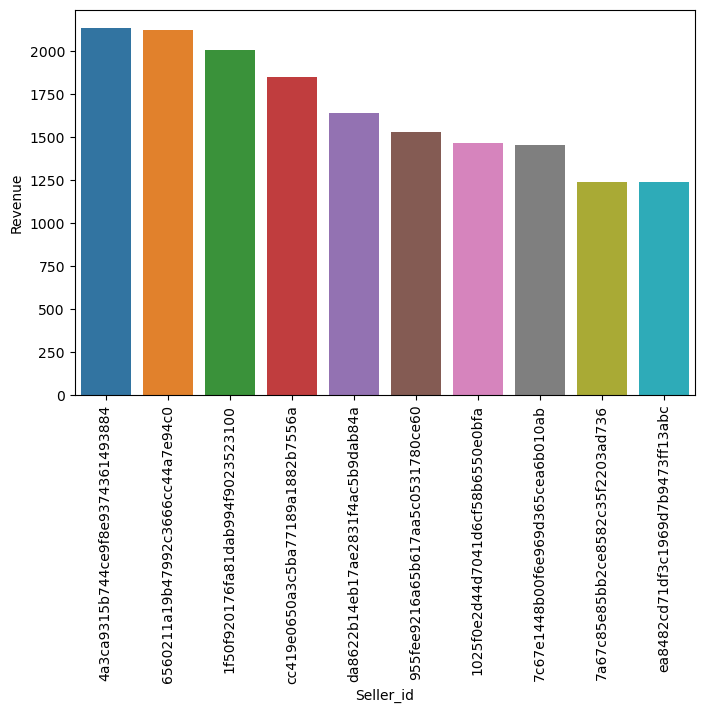

In [15]:
plt.figure(figsize=(8,5))
sns.barplot(x=df['Seller_id'], y=df['Revenue'],data=df)
plt.xticks(rotation=90)
plt.xlabel('Seller_id')
plt.ylabel('Revenue')

plt.show()

## 1. Calculate the moving average of order values for each customer over their order history.

In [16]:
query = ''' select 
      customer_id,
      order_purchase_timestamp,
      payment,
      avg(payment) over (partition by customer_id order by order_purchase_timestamp
      rows between 2 preceding and current row) as moving_average
 from 
     (select 
     orders.customer_id,
      orders.order_purchase_timestamp,
      payments.payment_value as payment
from orders
join payments on orders.order_id = payments.order_id)as a'''

cursor.execute(query)
data = cursor.fetchall()

df=pd.DataFrame(data,columns=['Customer_id','order_purchase_time','payment','moving_avg'])
df.head()

,Customer_id,order_purchase_time,payment,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998


## 2. Calculate the cumulative sales per month for each year.

In [17]:
query = ''' select year, month, payment, sum(payment) over (order by year, month) as cumulative_sales from
(select
    year(orders.order_purchase_timestamp) year,
    month(orders.order_purchase_timestamp) month,
    round(sum(payments.payment_value),2) as payment
from 
    orders join payments
    on orders.order_id = payments.order_id
group by year, month 
order by year, month) as a'''

cursor.execute(query)
data = cursor.fetchall()

df = pd.DataFrame(data, columns=['Year','Month','Payments','Cumulative_Sales'])
df.head()

,Year,Month,Payments,Cumulative_Sales
0,2016,9,504.48,504.48
1,2016,10,118180.96,118685.44
2,2016,12,39.24,118724.68
3,2017,1,276976.08,395700.76
4,2017,2,583816.02,979516.78


## Q3. Calculate the year-over-year growth rate of total sales.

In [18]:
query = ''' with a as
(select
    year(orders.order_purchase_timestamp) year,
    round(sum(payments.payment_value),2) as payment
from 
    orders join payments
    on orders.order_id = payments.order_id
group by year
order by year) 
select year,payment, ((payment - lag(payment ,1) over(order by year))/ lag(payment ,1) over(order by year)) * 100 as prev_yr_pay from a'''

cursor.execute(query)

data = cursor.fetchall()

pd.DataFrame(data, columns=['year','payments','prev_yr_pay'])

,year,payments,prev_yr_pay
0,2016,118724.68,NaN
1,2017,14499493.46,12112.703761
2,2018,17399526.10,20.000924


#### Year 2017 has highest growth rate among all years

## Q4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [19]:
query = '''with a as(select
     customer_id,
	min(order_purchase_timestamp) as first_order
from orders
group by customer_id),
b as
    ( select 
       a.customer_id,
       count(distinct orders.order_purchase_timestamp) from a join orders 
       on a.customer_id = orders.customer_id
       and orders.order_purchase_timestamp > a.first_order
       and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
       group by a.customer_id)
       
select (count(distinct a.customer_id)/count(distinct b.customer_id))*100 from a left join b on a.customer_id = b.customer_id'''

cursor.execute(query)

data = cursor.fetchall()

data

((None,),)

#### No customer has purchase any product within 6 months of timespam

## Q5. Identify the top 3 customers who spent the most money in each year.

In [29]:
query = '''  select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 '''

cursor.execute(query)

data = cursor.fetchall()

df=pd.DataFrame(data, columns=('Year','Customer_id','Payments','Rank'))
df

,Year,Customer_id,Payments,Rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,2847.100098,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,2801.479980,2
2,2016,4a06381959b6670756de02e07b83815f,2455.560059,3
3,2017,1617b1357756262bfa56ab541c47bc16,27328.160156,1
4,2017,c6e2731c5b391845f6800c97401a43a9,13858.620117,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,13453.320312,3
6,2018,ec5b2ba62e574342386871631fafd3fc,14549.759766,1
7,2018,f48d464a0baaea338cb25f816991ab1f,13844.419922,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,9618.879883,3


<IPython.core.display.Javascript object>

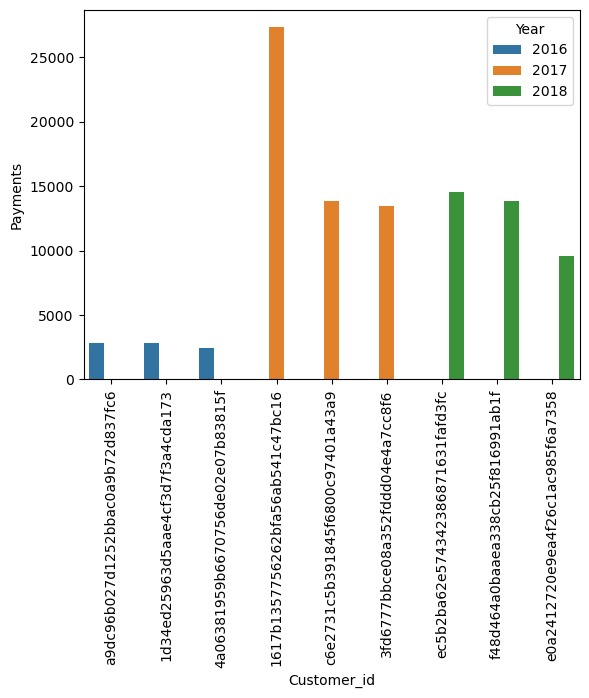

In [28]:
# convert Year(int) to Year(str)
df['Year']=df["Year"].astype(str)

# Plot barplot for payments and customer_id
sns.barplot(x = "Customer_id", y = "Payments", data = df, hue = "Year")
plt.xticks(rotation = 90)
plt.show()

#### In year 2017 customer has highest purchase value.